In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import itertools

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '../input/skin-cancer-mnist-ham10000'

In [5]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [6]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [7]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [8]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [9]:
df['age'].fillna((df['age'].mean()), inplace=True)

<ipython-input-9-6c9f6c8fc82c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna((df['age'].mean()), inplace=True)


In [10]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [11]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [12]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [13]:
print("Original labels:", y_train_o)
print("Shape of y_train:", y_train_o.shape)

Original labels: 8442    4
2908    1
8909    4
58      2
2960    1
       ..
664     2
7540    4
7221    4
1318    5
8915    4
Name: cell_type_idx, Length: 8012, dtype: int8
Shape of y_train: (8012,)


In [14]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
print("Shape of y_train:", y_train.shape)

Shape of y_train: (8012, 7)


In [15]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

print("Shape of y_train:", y_train.shape)

Shape of y_train: (7210, 7)


In [16]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
#x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [17]:
print(f"x_train shape before resampling: {x_train.shape}")
print("Shape of y_train:", y_train.shape)

x_train shape before resampling: (7210, 75, 100, 3)
Shape of y_train: (7210, 7)


In [18]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
#x_validate = x_validate.reshape(x_validate.shape[0], -1)
print(f"Flattened X_class shape: {x_train.shape}")
print("Shape of y_train:", y_train.shape)

Flattened X_class shape: (7210, 22500)
Shape of y_train: (7210, 7)


In [19]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

class COSHySMOTE:
    def __init__(self, target_distribution=None, cluster_sizes=None, random_state=None):
        """
        Initialize COSHySMOTE.

        Parameters:
        - target_distribution: dict, desired class distribution after resampling. Example: {0: 10, 1: 20}.
        - cluster_sizes: dict, number of clusters to use per class. Example: {0: 5, 1: 3}.
        - random_state: int, random state for reproducibility.
        """
        self.target_distribution = target_distribution
        self.cluster_sizes = cluster_sizes
        self.random_state = random_state

    def fit_resample(self, X, y):
        """
        Fit and resample the dataset.

        Parameters:
        - X: numpy array, feature matrix.
        - y: numpy array, labels.

        Returns:
        - X_resampled: numpy array, resampled feature matrix.
        - y_resampled: numpy array, resampled labels.
        """
        unique_classes, class_counts = np.unique(y, return_counts=True)
        original_distribution = dict(zip(unique_classes, class_counts))

        print(f"Original class distribution: {original_distribution}")

        if self.target_distribution is None:
            raise ValueError("Target distribution must be specified.")

        X_resampled, y_resampled = [], []
        
        for cls in unique_classes:
            class_indices = np.where(y == cls)[0]
            X_class = X[class_indices]
            n_clusters = self.cluster_sizes.get(cls, min(len(X_class), 5))  # Default to min(len, 5)

            # Clustering
            print(f"Clustering {len(X_class)} samples into {n_clusters} clusters for class {cls}.")
            kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_state)
            cluster_labels = kmeans.fit_predict(X_class)
            
            # Retain one sample per cluster
            retained_samples = self._retain_samples(X_class, cluster_labels, kmeans)
            X_resampled.extend(retained_samples)
            y_resampled.extend([cls] * len(retained_samples))
            print(f"Clusters: {n_clusters}, Retained Samples for class {cls}: {len(retained_samples)}")

            # Generate synthetic samples if needed
            target_count = self.target_distribution.get(cls, len(retained_samples))
            if target_count > len(retained_samples):
                synthetic_count = target_count - len(retained_samples)
                synthetic_samples = self._generate_synthetic_samples(
                    X_class, retained_samples, cluster_labels, kmeans, synthetic_count
                )
                X_resampled.extend(synthetic_samples)
                y_resampled.extend([cls] * len(synthetic_samples))
                print(f"Generated {len(synthetic_samples)} synthetic samples for class {cls}.")

        # Verify final distribution
        resampled_distribution = dict(zip(*np.unique(y_resampled, return_counts=True)))
        print(f"Resampled class distribution: {resampled_distribution}")

        return np.array(X_resampled), np.array(y_resampled)

    def _retain_samples(self, X_class, cluster_labels, kmeans):
        """
        Retain one sample per cluster.

        Parameters:
        - X_class: numpy array, samples of the class.
        - cluster_labels: numpy array, cluster assignments.
        - kmeans: fitted KMeans object.

        Returns:
        - List of retained samples.
        """
        retained_samples = []
        for cluster_id in np.unique(cluster_labels):
            cluster_indices = np.where(cluster_labels == cluster_id)[0]
            cluster_center = kmeans.cluster_centers_[cluster_id]
            closest_idx = cluster_indices[
                np.argmin(np.linalg.norm(X_class[cluster_indices] - cluster_center, axis=1))
            ]
            retained_samples.append(X_class[closest_idx])
        return retained_samples

    def _generate_synthetic_samples(self, X_class, retained_samples, cluster_labels, kmeans, synthetic_count):
        """
        Generate synthetic samples.

        Parameters:
        - X_class: numpy array, samples of the class.
        - retained_samples: list, retained samples.
        - cluster_labels: numpy array, cluster assignments.
        - kmeans: fitted KMeans object.
        - synthetic_count: int, number of synthetic samples to generate.

        Returns:
        - List of synthetic samples.
        """
        synthetic_samples = []
        nearest_neighbors = NearestNeighbors(n_neighbors=5).fit(X_class)

        for _ in range(synthetic_count):
            cluster_id = np.random.choice(np.unique(cluster_labels))
            cluster_indices = np.where(cluster_labels == cluster_id)[0]
            random_idx = np.random.choice(cluster_indices)
            base_sample = X_class[random_idx]

            # Find neighbors within the cluster
            neighbors = nearest_neighbors.kneighbors(base_sample.reshape(1, -1), return_distance=False)[0]
            neighbor_idx = np.random.choice(neighbors)
            neighbor_sample = X_class[neighbor_idx]

            # Interpolate to create a synthetic sample
            alpha = np.random.uniform(0, 1)
            synthetic_sample = base_sample + alpha * (neighbor_sample - base_sample)
            synthetic_samples.append(synthetic_sample)

        return synthetic_samples


In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=500)  # Retain 500 principal components
x_train = pca.fit_transform(x_train)

Original class distribution: {0: 236, 1: 373, 2: 795, 3: 83, 4: 4839, 5: 785, 6: 99}
Clustering 236 samples into 1 clusters for class 0.
Clusters: 1, Retained Samples for class 0: 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generated 4838 synthetic samples for class 0.
Clustering 373 samples into 1 clusters for class 1.
Clusters: 1, Retained Samples for class 1: 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generated 4838 synthetic samples for class 1.
Clustering 795 samples into 1 clusters for class 2.
Clusters: 1, Retained Samples for class 2: 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generated 4838 synthetic samples for class 2.
Clustering 83 samples into 1 clusters for class 3.
Clusters: 1, Retained Samples for class 3: 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generated 4838 synthetic samples for class 3.
Clustering 4839 samples into 4 clusters for class 4.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters: 4, Retained Samples for class 4: 4
Generated 4835 synthetic samples for class 4.
Clustering 785 samples into 1 clusters for class 5.
Clusters: 1, Retained Samples for class 5: 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generated 4838 synthetic samples for class 5.
Clustering 99 samples into 1 clusters for class 6.
Clusters: 1, Retained Samples for class 6: 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generated 4838 synthetic samples for class 6.
Resampled class distribution: {0: 4839, 1: 4839, 2: 4839, 3: 4839, 4: 4839, 5: 4839, 6: 4839}
Resampled class distribution: {0: 4839, 1: 4839, 2: 4839, 3: 4839, 4: 4839, 5: 4839, 6: 4839}


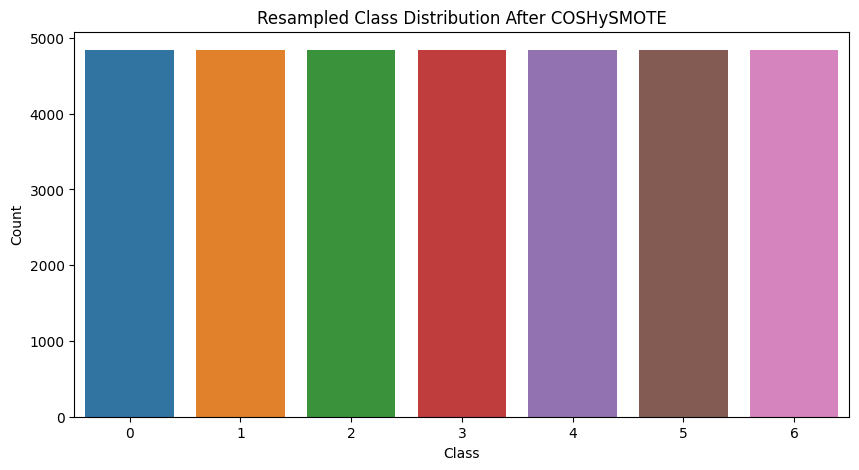

In [21]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate class counts
class_counts = Counter(np.argmax(y_train, axis=1))  # Use np.argmax if y_train is one-hot encoded
classes = list(class_counts.keys())  # Get all unique classes

# Determine total samples for balancing
total_samples = max(class_counts.values())  # Use the maximum count as the target for oversampling

# Desired samples for each class (make all classes proportional)
target_distribution = {cls: total_samples for cls in classes}

# Adjust retained samples and cluster sizes for each class
retained_samples = {cls: max(1, min(100, class_counts[cls] // 1000)) for cls in classes}
cluster_sizes = {cls: retained_samples[cls] for cls in classes}

# COSHySMOTE resampling
coshysmote = COSHySMOTE(
    target_distribution=target_distribution,
    cluster_sizes=cluster_sizes,
    random_state=42
)
X_resampled, y_resampled = coshysmote.fit_resample(x_train, np.argmax(y_train, axis=1))  # Convert one-hot to integer labels

# Check new resampled distribution
resampled_class_counts = Counter(y_resampled)
print("Resampled class distribution:", dict(resampled_class_counts))

# Visualize the resampled class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=y_resampled, palette="tab10")  # Use tab10 for more class colors
plt.title("Resampled Class Distribution After COSHySMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Base model for Bagging and Boosting
base_model = RandomForestClassifier(random_state=42)

# Bagging OVA
bagging_ova = OneVsRestClassifier(BaggingClassifier(base_model, random_state=42))
bagging_ova.fit(X_train, y_train)
bagging_ova_predictions = bagging_ova.predict(X_test)
print("Bagging OVA Classification Report:")
print(classification_report(y_test, bagging_ova_predictions))
bagging_ova_accuracy = accuracy_score(y_test, bagging_ova_predictions)
print("Bagging OVA Accuracy:", bagging_ova_accuracy)

Bagging OVA Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       963
           1       0.99      1.00      1.00       984
           2       0.98      0.95      0.96       994
           3       1.00      1.00      1.00       945
           4       0.95      0.90      0.93       978
           5       0.91      0.98      0.95       977
           6       1.00      1.00      1.00       934

    accuracy                           0.98      6775
   macro avg       0.98      0.98      0.98      6775
weighted avg       0.98      0.98      0.98      6775

Bagging OVA Accuracy: 0.9759409594095941


In [24]:

# Bagging OVO
bagging_ovo = OneVsOneClassifier(BaggingClassifier(base_model, random_state=42))
bagging_ovo.fit(X_train, y_train)
bagging_ovo_predictions = bagging_ovo.predict(X_test)
print("Bagging OVO Classification Report:")
print(classification_report(y_test, bagging_ovo_predictions))
bagging_ovo_accuracy = accuracy_score(y_test, bagging_ovo_predictions)
print("Bagging OVO Accuracy:", bagging_ovo_accuracy)

Bagging OVO Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       963
           1       1.00      1.00      1.00       984
           2       0.98      0.93      0.96       994
           3       1.00      1.00      1.00       945
           4       0.93      0.85      0.89       978
           5       0.85      0.97      0.91       977
           6       1.00      1.00      1.00       934

    accuracy                           0.96      6775
   macro avg       0.97      0.96      0.96      6775
weighted avg       0.97      0.96      0.96      6775

Bagging OVO Accuracy: 0.9635424354243542


In [25]:

# Boosting OVA
boosting_ova = OneVsRestClassifier(XGBClassifier(random_state=42))
boosting_ova.fit(X_train, y_train)
boosting_ova_predictions = boosting_ova.predict(X_test)
print("Boosting OVA Classification Report:")
print(classification_report(y_test, boosting_ova_predictions))
boosting_ova_accuracy = accuracy_score(y_test, boosting_ova_predictions)
print("Boosting OVA Accuracy:", boosting_ova_accuracy)


Boosting OVA Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       963
           1       0.98      1.00      0.99       984
           2       0.98      0.97      0.98       994
           3       1.00      1.00      1.00       945
           4       0.97      0.91      0.94       978
           5       0.93      0.98      0.96       977
           6       1.00      1.00      1.00       934

    accuracy                           0.98      6775
   macro avg       0.98      0.98      0.98      6775
weighted avg       0.98      0.98      0.98      6775

Boosting OVA Accuracy: 0.9796309963099631


In [26]:

# Boosting OVO
boosting_ovo = OneVsOneClassifier(XGBClassifier(random_state=42))
boosting_ovo.fit(X_train, y_train)
boosting_ovo_predictions = boosting_ovo.predict(X_test)
print("Boosting OVO Classification Report:")
print(classification_report(y_test, boosting_ovo_predictions))
boosting_ovo_accuracy = accuracy_score(y_test, boosting_ovo_predictions)
print("Boosting OVO Accuracy:", boosting_ovo_accuracy)


Boosting OVO Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       963
           1       0.98      1.00      0.99       984
           2       0.98      0.97      0.97       994
           3       1.00      1.00      1.00       945
           4       0.96      0.90      0.93       978
           5       0.92      0.98      0.95       977
           6       1.00      1.00      1.00       934

    accuracy                           0.98      6775
   macro avg       0.98      0.98      0.98      6775
weighted avg       0.98      0.98      0.98      6775

Boosting OVO Accuracy: 0.9757933579335794


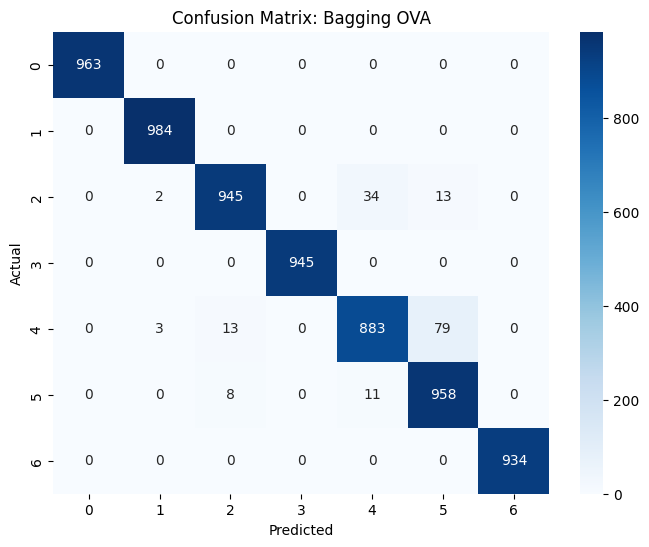

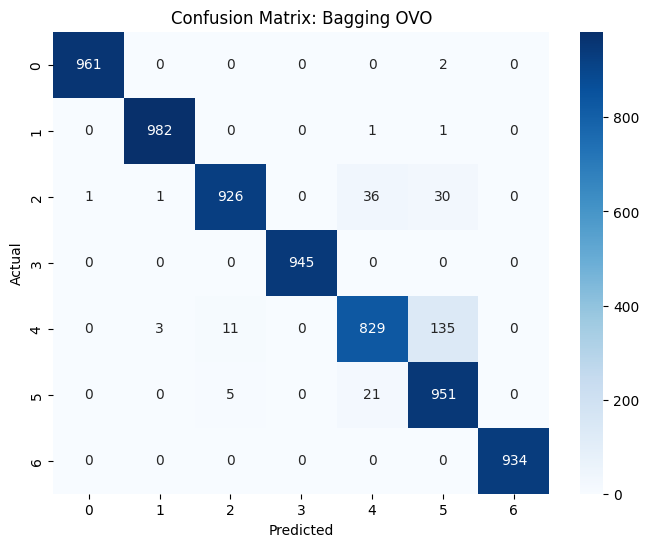

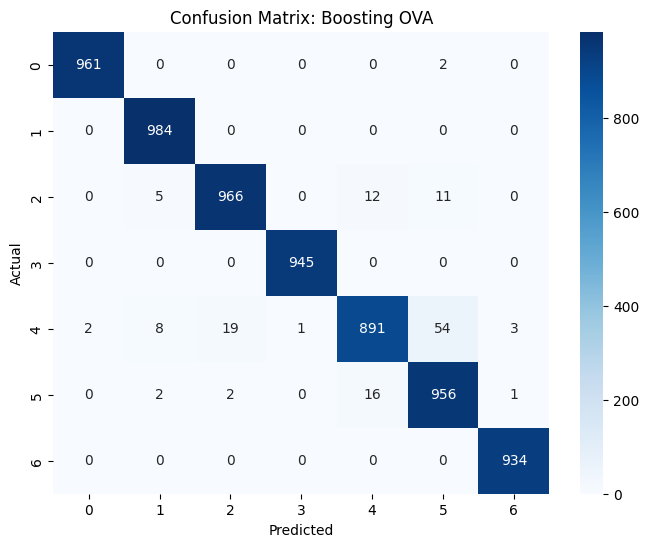

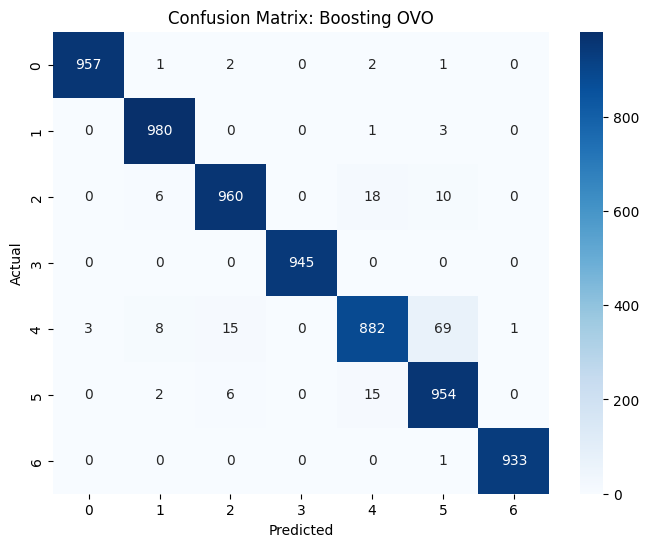

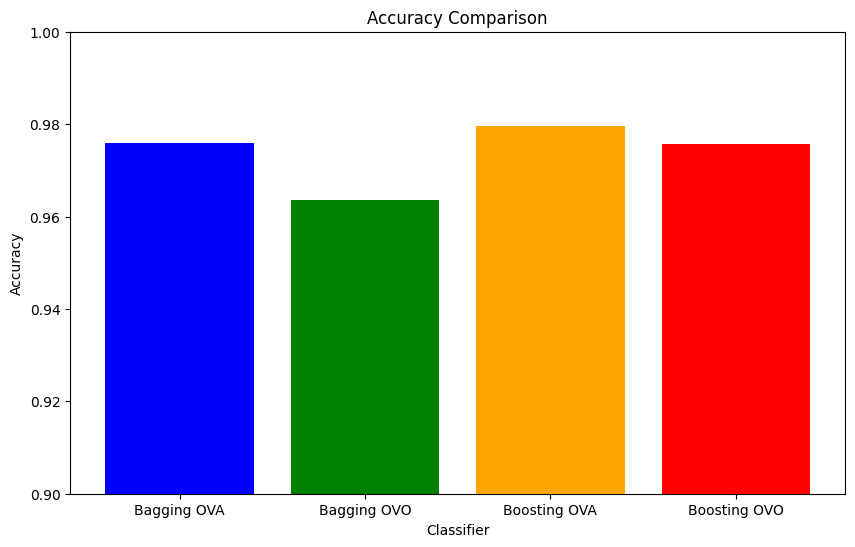

In [27]:

# Visualization: Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_resampled)), yticklabels=sorted(set(y_resampled)))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot confusion matrices for each classifier
plot_confusion_matrix(y_test, bagging_ova_predictions, "Confusion Matrix: Bagging OVA")
plot_confusion_matrix(y_test, bagging_ovo_predictions, "Confusion Matrix: Bagging OVO")
plot_confusion_matrix(y_test, boosting_ova_predictions, "Confusion Matrix: Boosting OVA")
plot_confusion_matrix(y_test, boosting_ovo_predictions, "Confusion Matrix: Boosting OVO")

# Accuracy comparison bar chart
classifiers = ['Bagging OVA', 'Bagging OVO', 'Boosting OVA', 'Boosting OVO']
accuracies = [bagging_ova_accuracy, bagging_ovo_accuracy, boosting_ova_accuracy, boosting_ovo_accuracy]
plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.ylim(0.9, 1.0)
plt.show()

In [28]:
# Define classifiers
classifiers = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Iterate over classifiers for both OVA and OVO
for clf_name, clf in classifiers.items():
    print(f"\n{'='*20} {clf_name} {'='*20}")
    
    # One-vs-All (OVA) Classification
    print("\nTraining One-vs-All Classifier...")
    ova_classifier = OneVsRestClassifier(clf)
    ova_classifier.fit(X_train, y_train)
    ova_predictions = ova_classifier.predict(X_test)
    print("\nOne-vs-All Classification Report:")
    print(classification_report(y_test, ova_predictions))
    print("OVA Accuracy:", accuracy_score(y_test, ova_predictions))
    
    # One-vs-One (OVO) Classification
    print("\nTraining One-vs-One Classifier...")
    ovo_classifier = OneVsOneClassifier(clf)
    ovo_classifier.fit(X_train, y_train)
    ovo_predictions = ovo_classifier.predict(X_test)
    print("\nOne-vs-One Classification Report:")
    print(classification_report(y_test, ovo_predictions))
    print("OVO Accuracy:", accuracy_score(y_test, ovo_predictions))


==================== XGBoost ====================

Training One-vs-All Classifier...

One-vs-All Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       963
           1       0.98      1.00      0.99       984
           2       0.98      0.97      0.98       994
           3       1.00      1.00      1.00       945
           4       0.97      0.91      0.94       978
           5       0.93      0.98      0.96       977
           6       1.00      1.00      1.00       934

    accuracy                           0.98      6775
   macro avg       0.98      0.98      0.98      6775
weighted avg       0.98      0.98      0.98      6775

OVA Accuracy: 0.9796309963099631

Training One-vs-One Classifier...

One-vs-One Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       963
           1       0.98      1.00      0.99       984
           2    

In [29]:
# Define the base model (e.g., Random Forest)
base_model = RandomForestClassifier(random_state=42)

# Wrap the base model with OneVsRestClassifier
ova_classifier = OneVsRestClassifier(base_model)

# Train the OVA model
ova_classifier.fit(X_train, y_train)

# Predict on the test set
ova_predictions = ova_classifier.predict(X_test)

# Evaluate the OVA model
print("One-vs-All Classification Report:")
print(classification_report(y_test, ova_predictions))
print("OVA Accuracy:", accuracy_score(y_test, ova_predictions))


One-vs-All Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       963
           1       0.99      1.00      1.00       984
           2       0.98      0.95      0.96       994
           3       1.00      1.00      1.00       945
           4       0.94      0.92      0.93       978
           5       0.93      0.98      0.96       977
           6       1.00      1.00      1.00       934

    accuracy                           0.98      6775
   macro avg       0.98      0.98      0.98      6775
weighted avg       0.98      0.98      0.98      6775

OVA Accuracy: 0.9780073800738007


In [30]:
from imblearn.ensemble import EasyEnsembleClassifier

# Initialize EasyEnsemble classifier
easy_ensemble = EasyEnsembleClassifier(random_state=42, n_estimators=10)
easy_ensemble.fit(X_train, y_train)

# Evaluate
y_pred_easy = easy_ensemble.predict(X_test)
print(classification_report(y_test, y_pred_easy))


              precision    recall  f1-score   support

           0       0.38      0.44      0.41       963
           1       0.39      0.31      0.35       984
           2       0.46      0.45      0.45       994
           3       0.40      0.50      0.44       945
           4       0.54      0.51      0.52       978
           5       0.46      0.46      0.46       977
           6       0.75      0.66      0.70       934

    accuracy                           0.47      6775
   macro avg       0.48      0.48      0.48      6775
weighted avg       0.48      0.47      0.48      6775



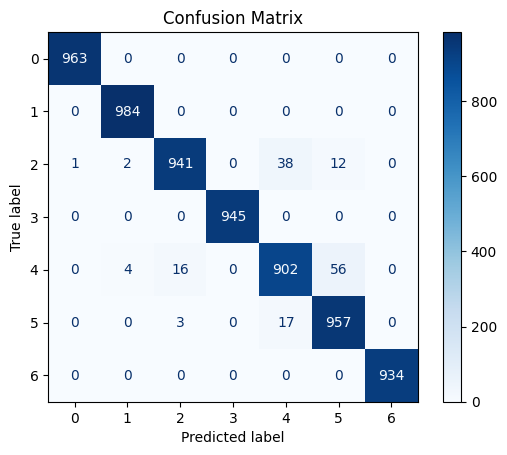

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, ova_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ova_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


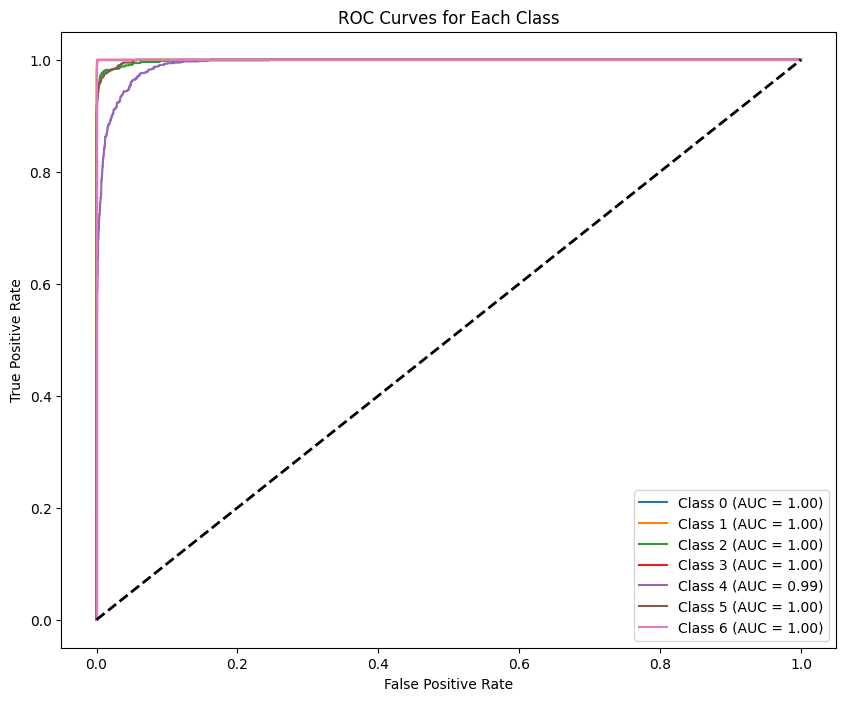

In [32]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=ova_classifier.classes_)
ova_probabilities = ova_classifier.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], ova_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {ova_classifier.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.show()


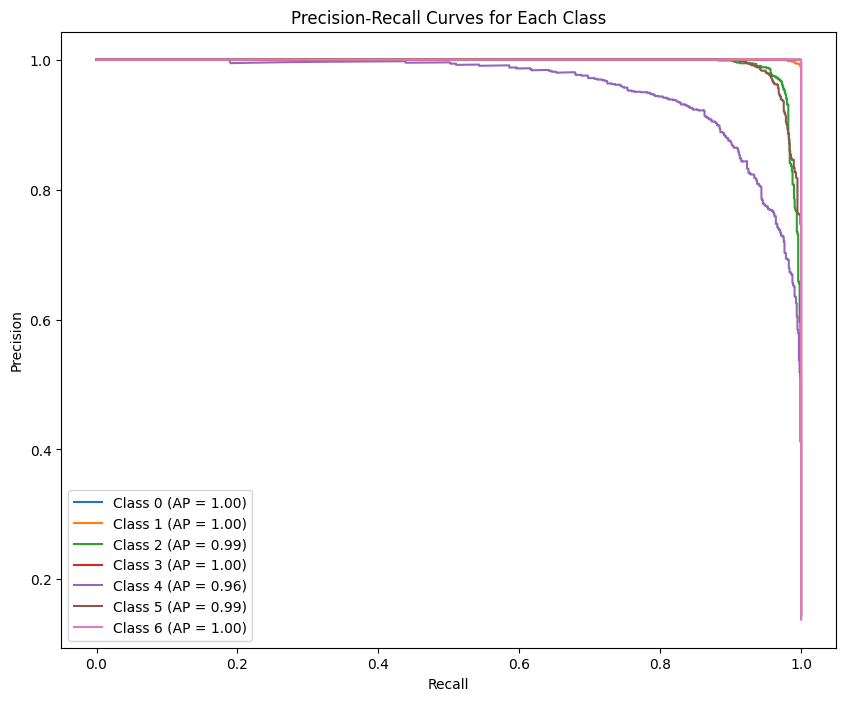

In [33]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))

# Plot precision-recall curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], ova_probabilities[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], ova_probabilities[:, i])
    plt.plot(recall, precision, label=f"Class {ova_classifier.classes_[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Each Class")
plt.legend(loc="lower left")
plt.show()


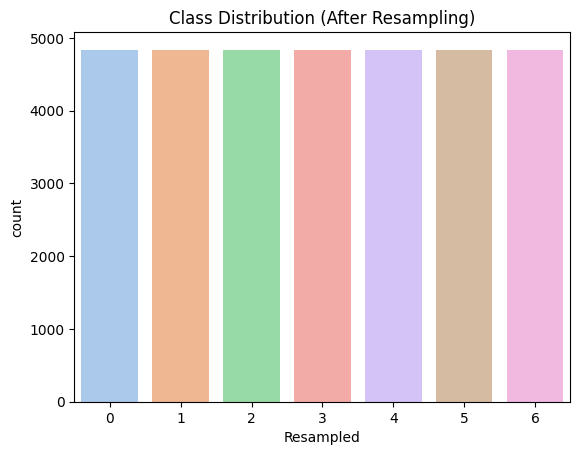

In [34]:
import pandas as pd
import seaborn as sns

# Class distribution before and after resampling
before_resample = pd.Series(y_resampled, name="Resampled")

# Plot bar plot
sns.countplot(x=before_resample, palette="pastel").set_title("Class Distribution (After Resampling)")
plt.show()


**OVO**

In [35]:
# Wrap the base model with OneVsOneClassifier
ovo_classifier = OneVsOneClassifier(base_model)

# Train the OVO model
ovo_classifier.fit(X_train, y_train)

# Predict on the test set
ovo_predictions = ovo_classifier.predict(X_test)

# Evaluate the OVO model
print("One-vs-One Classification Report:")
print(classification_report(y_test, ovo_predictions))
print("OVO Accuracy:", accuracy_score(y_test, ovo_predictions))


One-vs-One Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       963
           1       1.00      0.99      0.99       984
           2       0.98      0.94      0.96       994
           3       1.00      1.00      1.00       945
           4       0.93      0.88      0.91       978
           5       0.88      0.97      0.92       977
           6       1.00      1.00      1.00       934

    accuracy                           0.97      6775
   macro avg       0.97      0.97      0.97      6775
weighted avg       0.97      0.97      0.97      6775

OVO Accuracy: 0.9681180811808118


In [36]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate class counts
class_counts = Counter(np.argmax(y_train, axis=1))  # Use np.argmax if y_train is one-hot encoded
classes = list(class_counts.keys())  # Get all unique classes

# Determine total samples for balancing
total_samples = max(class_counts.values())  # Use the maximum count as the target for oversampling

# Desired samples for each class (make all classes proportional)
target_distribution = {cls: total_samples for cls in classes}

# Adjust retained samples and cluster sizes for each class
retained_samples = {cls: max(1, min(100, class_counts[cls] // 1000)) for cls in classes}
cluster_sizes = {cls: retained_samples[cls] for cls in classes}

# COSHySMOTE resampling
coshysmote = COSHySMOTE(
    target_distribution=target_distribution,
    cluster_sizes=cluster_sizes,
    random_state=42
)
X_resampled, y_resampled = coshysmote.fit_resample(x_train, np.argmax(y_train, axis=1))  # Convert one-hot to integer labels

# Check new resampled distribution
resampled_class_counts = Counter(y_resampled)
print("Resampled class distribution:", dict(resampled_class_counts))

# Visualize the resampled class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=y_resampled, palette="tab10")  # Use tab10 for more class colors
plt.title("Resampled Class Distribution After COSHySMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
wait


In [ ]:
from collections import Counter
# Adjust target samples for balanced distribution
total_majority = len(y_train[y_train == 0])
total_minority = len(y_train[y_train == 1])

# Desired total samples for each class
desired_minority_samples = total_majority // 2  # Keep the minority class size proportional to the majority
desired_majority_samples = desired_minority_samples

# Adjust retained samples and target synthetic samples
retained_samples = {
    0: min(100, total_majority // 1000),
    1: min(50, total_minority // 10)
}

target_samples = {
    0: desired_majority_samples,
    1: desired_minority_samples
}

# Apply COSHySMOTE
coshysmote = COSHySMOTE(
    target_samples,
    retained_samples,
    random_state=42
)
X_resampled, y_resampled = coshysmote.fit_resample(x_train, y_train)

# Check new resampled distribution
print("Resampled class distribution:", dict(Counter(y_resampled)))

# Visualize the resampled class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=y_resampled, palette=["#0101DF", "#DF0101"])
plt.title("Resampled Class Distribution After COSHySMOTE")
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming `y_resampled` contains the labels after balancing
# Relabel class names if needed (for clarity)
class_names = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'vasc',
    4: 'df',
    5: 'akiec',
    6: 'bcc'
}

# Map numeric labels to class names
y_resampled_named = [class_names[label] for label in y_resampled]

# Create a pandas DataFrame for visualization
df = pd.DataFrame({'Class': y_resampled_named})
class_counts = df['Class'].value_counts()

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title('Class Distribution After Balancing (HAM10000)', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()
